In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
import pandas as pd
import sys
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
import ast

In [2]:
#defenition of data path and excel file path
path = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/'
excel = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/ptbxl_database.csv'

In [3]:
import pandas as pd
import numpy as np
import ast
import wfdb
from torch.utils.data import Dataset
from torchvision import transforms
from scipy.signal import butter, filtfilt

class Custom_class(Dataset):
    def __init__(self, path, num_data, transform=None, data_split='train', fold=None):
        self.dat = pd.read_csv(path + 'ptbxl_database.csv' )
        self.col = self.dat['filename_hr']  # only 500 hz files are used for training
        self.label = self.dat['scp_codes']  # used for labeling
        self.strat_fold = self.dat['strat_fold']  # Load strat_fold column
        self.path = path
        self.transform = transform  # Initialize the transform attribute
        self.num_data = num_data
        self.data_split = data_split
        self.fold = fold

        # Load scp_statements.csv to map scp_codes to diagnostic classes
        self.scp_statements = pd.read_csv(path + 'scp_statements.csv')  # Adjust path as necessary
        self.scp_statements  = self.scp_statements [self.scp_statements.diagnostic == 1]
        self.diagnostic_classes = ['NORM','STTC','MI','HYP','CD','Other']
        self.num_classes = len(self.diagnostic_classes)

        if self.data_split == 'train':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] != fold)]
        elif self.data_split == 'test':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == fold)]
        elif self.data_split == 'val':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == fold)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]  # Adjust index to match filtered data
        y, _ = wfdb.rdsamp(self.path + self.col[idx])  # Use channel 0
        y = y.astype(np.float32)
        y = np.transpose(y)

        # Apply filtering
        y = self.bandpass_filter(y, 1, 47, 500)  # applying BPF

        # Normalize using z-score
        y = self.z_score_normalize(y)
        y = y.astype(np.float32)

        scp_code_dict = ast.literal_eval(self.label[idx])  # Fetching label from the scp_codes column
        first_key = max(scp_code_dict, key=scp_code_dict.get)
        # tmp = []
        result = self.scp_statements.loc[self.scp_statements.iloc[:,0] == first_key, 'diagnostic_class'].tolist()
        # tmp.append(result)
        diagnostic_classes = result
        # Determine the diagnostic class from scp_codes
        # diagnostic_classes = self.get_diagnostic_class(first_key)
        # diagnostic_classes = np.array(diagnostic_classes)
        # Transform diagnostic_class into a label (assuming you have a mapping or encoding)
        label = np.zeros(self.num_classes, dtype=np.float32)
        if (len(diagnostic_classes)==0):
            index = self.diagnostic_classes.index('Other')
        else:
            diagnostic_classes = diagnostic_classes[0]
            index = self.diagnostic_classes.index(diagnostic_classes)
        label[index] = 1        
        # Set the corresponding position in the label array to 1


        if self.transform:
            y = self.transform(y)

        return y[0, :, :], label

    def get_diagnostic_class(self,y_dic):
        tmp = []
        result = self.scp_statements.loc[self.scp_statements.iloc[:,0] == y_dic, 'diagnostic_class']
        tmp.append(result.values)
        return result.values

    def bandpass_filter(self, data, lowcut, highcut, fs, order=3):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data, axis=1)
        return y

    def z_score_normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        normalized_data = (data - mean) / std
        return normalized_data


transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_dataset = Custom_class( path, num_data=7000, transform=transform, data_split='train', fold=10)
val_dataset = Custom_class( path, num_data=7000, transform=transform, data_split='val', fold=9)
test_dataset = Custom_class( path, num_data=7000, transform=transform, data_split='test', fold=8)


In [5]:
print(f"Number of data in training set : {len(train_dataset)}")
print(f"Number of data in training set :{len(val_dataset)}")

Number of data in training set : 6171
Number of data in training set :812


In [6]:
#MODEL DEFINITION
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Res_Block_1
class ResBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the Res_Block_2
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the complete ResNet-50 model with Self-Attention
class ResNet50(nn.Module):
    def __init__(self, input_channels=12, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock1, 64, 128, 1)
        self.layer2 = self._make_layer(ResBlock2, 128, 128, 2)
        self.layer3 = self._make_layer(ResBlock1, 128, 256, 1)
        self.layer4 = self._make_layer(ResBlock2, 256, 256, 3)
        self.layer5 = self._make_layer(ResBlock1, 256, 512, 1)
        self.layer6 = self._make_layer(ResBlock2, 512, 512, 5)
        self.layer7 = self._make_layer(ResBlock1, 512, 1024, 1)
        self.layer8 = self._make_layer(ResBlock2, 1024, 1024, 2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(p=0.5) #added to improve generalization
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 6)

    def _make_layer(self, block, in_channels, out_channels, blocks):
        layers = []
        layers.append(block(in_channels, out_channels))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)  # Use softmax for multi-class classification
        return x

# Instantiate the model and print the summary
model = ResNet50(input_channels=12, num_classes=6)

# Check if CUDA is available and move the model to the GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=2)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers=2)

In [8]:
from torch.optim.lr_scheduler import LambdaLR
import math

def lr_lambda(epoch):
    if epoch < 10:
        return 1.0
    else:
        return math.exp(-1)



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy


# Define your optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define your data loaders (train_dataloader, validation_dataloader)

num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Define your validation function
def validate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            _,labels = torch.max(labels,1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
       
        loss = criterion(outputs, labels)
        _,labels = torch.max(labels,1) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
    scheduler.step()

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validate the model
    val_loss, val_acc = validate_model(model, validation_dataloader, criterion)
    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    # Deep copy the model if the current validation accuracy is the best so far
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")

# Load best model weights
model.load_state_dict(best_model_wts)

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

Training - Epoch 1/20, Loss: 1.4087, Accuracy: 0.6276
Validation - Epoch 1/20, Loss: 1.4519, Accuracy: 0.5850
Training - Epoch 2/20, Loss: 1.4145, Accuracy: 0.6239
Validation - Epoch 2/20, Loss: 1.4104, Accuracy: 0.6268
Training - Epoch 3/20, Loss: 1.3902, Accuracy: 0.6505
Validation - Epoch 3/20, Loss: 1.4242, Accuracy: 0.6158
Training - Epoch 4/20, Loss: 1.3870, Accuracy: 0.6540
Validation - Epoch 4/20, Loss: 1.4421, Accuracy: 0.5961
Training - Epoch 5/20, Loss: 1.3843, Accuracy: 0.6544
Validation - Epoch 5/20, Loss: 1.3972, Accuracy: 0.6453
Training - Epoch 6/20, Loss: 1.3765, Accuracy: 0.6637
Validation - Epoch 6/20, Loss: 1.4126, Accuracy: 0.6244
Training - Epoch 7/20, Loss: 1.3763, Accuracy: 0.6646
Validation - Epoch 7/20, Loss: 1.4076, Accuracy: 0.6355
Training - Epoch 8/20, Loss: 1.3621, Accuracy: 0.6788
Validation - Epoch 8/20, Loss: 1.3633, Accuracy: 0.6810
Training - Epoch 9/20, Loss: 1.3492, Accuracy: 0.6944
Validation - Epoch 9/20, Loss: 1.3537, Accuracy: 0.6860
Training -

In [18]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

model = ResNet50(input_channels=12, num_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('/home/abhishek/rashad_internship/ecg_classification_using_resnet/best_model_multiclass_71acc.pth'))

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _,preds = torch.max(outputs,dim=1)
            _,labels = torch.max(labels,dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

# Example usage:
# Assuming `model` is your PyTorch model and `test_loader` is your test data loader
accuracy, confusion_matrix = test_model(model, test_dataloader)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)


Accuracy: 0.7429022082018928
Confusion Matrix:
[[292  10   6   0   2   0]
 [ 16  68   6   0   1   0]
 [ 17  10  52   0  11   0]
 [ 19  16   0   0   4   0]
 [ 21   8   6   0  59   0]
 [  3   0   5   0   2   0]]


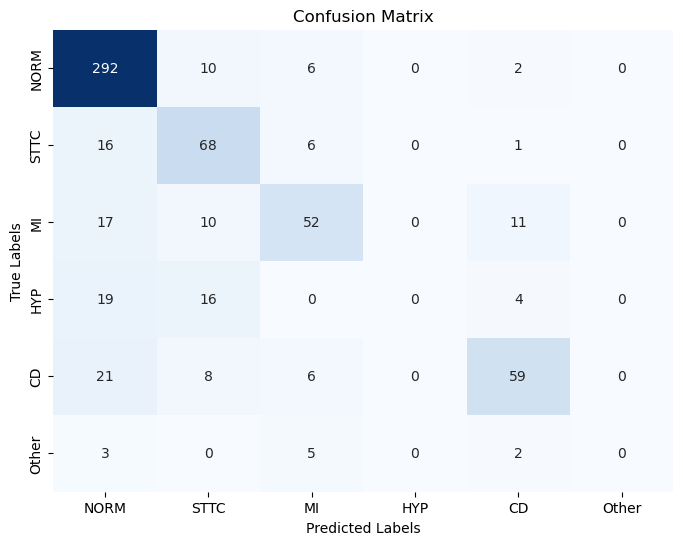

In [22]:
import seaborn as sns

class_names = ['NORM', 'STTC', 'MI', 'HYP', 'CD', 'Other']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()